<a href="https://colab.research.google.com/github/Mike-Xie/DS-Unit-2-Build-Week/blob/master/Mike_Xie_Unit_2_Build_Week.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Imports

In [0]:
%%capture
import sys

if 'google.colab' in sys.modules:
    # Install packages in Colab
    !pip install category_encoders==2.*
    !pip install pandas-profiling==2.*

In [3]:
!wget https://github.com/bowswung/voobly-scraper/raw/master/data/MatchData/20190208/matchDump.csv.zip

--2020-01-10 12:53:49--  https://github.com/bowswung/voobly-scraper/raw/master/data/MatchData/20190208/matchDump.csv.zip
Resolving github.com (github.com)... 140.82.118.3
Connecting to github.com (github.com)|140.82.118.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://media.githubusercontent.com/media/bowswung/voobly-scraper/master/data/MatchData/20190208/matchDump.csv.zip [following]
--2020-01-10 12:53:49--  https://media.githubusercontent.com/media/bowswung/voobly-scraper/master/data/MatchData/20190208/matchDump.csv.zip
Resolving media.githubusercontent.com (media.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to media.githubusercontent.com (media.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 49029198 (47M) [application/zip]
Saving to: ‘matchDump.csv.zip’

matchDump.csv.zip   100%[===================>]  46.76M   225MB/s    in 0.2s    

202

In [4]:
!unzip matchDump.csv.zip

Archive:  matchDump.csv.zip
  inflating: matchDump.csv           


In [5]:
!head matchDump.csv

MatchId,MatchUrl,MatchDate,MatchDuration,MatchLadder,MatchMap,MatchMods,MatchPlayerId,MatchPlayerName,MatchPlayerTeam,MatchPlayerCivId,MatchPlayerCivName,MatchPlayerWinner,MatchPlayerPreRating,MatchPlayerPostRating,MatchPlayerRecording
17827685,https://www.voobly.com/match/view/17827685,2018-05-27T18:14:00,520,Match Stats Only,=V= CBA Hero AC V13.scx,v1.5 Beta R6,123972487,___Oreo,1,9,Saracens,1,1584,1600,
17827685,https://www.voobly.com/match/view/17827685,2018-05-27T18:14:00,520,Match Stats Only,=V= CBA Hero AC V13.scx,v1.5 Beta R6,125049367,___Dm,2,9,Saracens,0,1616,1600,
17827728,https://www.voobly.com/match/view/17827728,2018-05-27T18:21:00,661,Match Stats Only,=V= CBA Hero AC V13.scx,v1.5 Beta R6,123972487,___Oreo,1,13,Celts,1,1584,1600,
17827728,https://www.voobly.com/match/view/17827728,2018-05-27T18:21:00,661,Match Stats Only,=V= CBA Hero AC V13.scx,v1.5 Beta R6,125049367,___Dm,2,13,Celts,0,1616,1600,
17832641,https://www.voobly.com/match/view/17832641,2018-05-28T11:25:00,762,

In [36]:
# imports 
import matplotlib.pyplot as plt
plt.rcParams['figure.dpi'] = 72
import pandas as pd
import seaborn as sns
import category_encoders as ce
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.pipeline import make_pipeline
pd.options.display.max_rows = 999
pd.options.display.max_columns = 100

# drop columns with meta data that are useless
df = pd.read_csv('matchDump.csv', header=0, engine='python')

cols_to_keep = ['MatchId','MatchMods','MatchMap','MatchLadder','MatchDuration','MatchPlayerTeam','MatchPlayerCivId','MatchPlayerCivName','MatchPlayerWinner','MatchPlayerPreRating']

df = df[cols_to_keep]

df.shape, df.head(5)


((1263808, 10),
     MatchId     MatchMods                 MatchMap       MatchLadder  \
 0  17827685  v1.5 Beta R6  =V= CBA Hero AC V13.scx  Match Stats Only   
 1  17827685  v1.5 Beta R6  =V= CBA Hero AC V13.scx  Match Stats Only   
 2  17827728  v1.5 Beta R6  =V= CBA Hero AC V13.scx  Match Stats Only   
 3  17827728  v1.5 Beta R6  =V= CBA Hero AC V13.scx  Match Stats Only   
 4  17832641  v1.5 Beta R6  =V= CBA Hero AC V13.scx  Match Stats Only   
 
    MatchDuration MatchPlayerTeam MatchPlayerCivId MatchPlayerCivName  \
 0            520               1                9           Saracens   
 1            520               2                9           Saracens   
 2            661               1               13              Celts   
 3            661               2               13              Celts   
 4            762               1               14            Spanish   
 
   MatchPlayerWinner MatchPlayerPreRating  
 0                 1                 1584  
 1              

# EDA & Wrangling Part 1 With 1 Player per Column

The dataframe starts with only one player per row
and it's a lot easier to do some of my wrangling once here and then
make features that are say, differences in elo score after reformatting in 
part two which put each row into both players in the match

In [0]:
# I want to predict which player wins

target = 'MatchPlayerWinner'

# This is 50/50 since odds are P1 and evens are P2 for a baseline

In [39]:
df[target].describe()

count     1263808
unique          3
top             0
freq       647589
Name: MatchPlayerWinner, dtype: object

In [40]:
df['MatchLadder'].value_counts()

RM - Team           723786
RM - 1v1            411718
Match Stats Only     81083
DM - Team            40249
DM - 1v1              6972
Name: MatchLadder, dtype: int64

In [0]:
# only do 1v1 on random map game mode

rm_1v1 = df[df['MatchLadder'] == 'RM - 1v1']

In [0]:
# remove ones with errors
rm_1v1 = rm_1v1[rm_1v1.MatchPlayerPreRating != '*VooblyErrorPlayerNotFound*']

# make into ints
rm_1v1['MatchPlayerCivId'] = rm_1v1['MatchPlayerCivId'].astype(int)
rm_1v1['MatchPlayerWinner'] = rm_1v1['MatchPlayerWinner'].astype(int)
rm_1v1['MatchPlayerPreRating'] = rm_1v1['MatchPlayerPreRating'].astype(int)
rm_1v1.dtypes

# any civ IDs above 31 are errors according to the readme
rm_1v1 = rm_1v1[rm_1v1['MatchPlayerCivId'] < 32]

In [43]:
# drop redundant labels

rm_1v1 = rm_1v1.drop(labels=['MatchLadder','MatchPlayerTeam'], axis=1)
rm_1v1.head()

,MatchId,MatchMods,MatchMap,MatchDuration,MatchPlayerCivId,MatchPlayerCivName,MatchPlayerWinner,MatchPlayerPreRating
728,18658367,"v1.5 Beta R7, WololoKingdoms",Arabia,1055,16,Mayans,1,1599
729,18658367,"v1.5 Beta R7, WololoKingdoms",Arabia,1055,11,Vikings,0,1600
730,18658419,1.4 RC,Custom,3361,18,Koreans,1,1629
731,18658419,1.4 RC,Custom,3361,17,Huns,0,1548
732,18658476,"v1.5 Beta R7, WololoKingdoms",Nomad,3369,6,Chinese,1,1975


In [44]:
rm_1v1.dtypes 

MatchId                  int64
MatchMods               object
MatchMap                object
MatchDuration            int64
MatchPlayerCivId         int64
MatchPlayerCivName      object
MatchPlayerWinner        int64
MatchPlayerPreRating     int64
dtype: object

In [45]:
rm_1v1['MatchMods'].describe()

# don't have time to see what all the mods do/don't understand effect on gameplay balance/target demographics, make a note

count                           411123
unique                              40
top       v1.5 Beta R7, WololoKingdoms
freq                            292835
Name: MatchMods, dtype: object

In [46]:
rm_1v1['MatchMap'].describe()

count     411123
unique        57
top       Arabia
freq      273944
Name: MatchMap, dtype: object

In [47]:
rm_1v1.tail()

,MatchId,MatchMods,MatchMap,MatchDuration,MatchPlayerCivId,MatchPlayerCivName,MatchPlayerWinner,MatchPlayerPreRating
1263771,19250562,"v1.5 Beta R7, WololoKingdoms",Arabia,4797,8,Persians,0,1695
1263772,19250571,"v1.5 Beta R7, WololoKingdoms",Custom,2501,13,Celts,1,1933
1263773,19250571,"v1.5 Beta R7, WololoKingdoms",Custom,2501,12,Mongols,0,1909
1263774,19250581,"v1.5 Beta R7, WololoKingdoms",Custom,4080,24,Portuguese,1,1542
1263775,19250581,"v1.5 Beta R7, WololoKingdoms",Custom,4080,19,Italians,0,1479


In [48]:
y = rm_1v1[target]

y.nunique()

2

In [49]:
y.value_counts() # baseline is 50/50 since only P1 or P2 can win a 1v1

0    205562
1    205561
Name: MatchPlayerWinner, dtype: int64

In [0]:
# Tier list feature implementation
# Civ ids from readme here:
# https://github.com/bowswung/voobly-scraper
# These are the same as the ids Voobly uses to display civ images. 

# 1	Britons
# 2	Franks
# 3	Goths
# 4	Teutons
# 5	Japanese
# 6	Chinese
# 7	Byzantines
# 8	Persians
# 9	Saracens
# 10	Turks
# 11	Vikings
# 12	Mongols
# 13	Celts
# 14	Spanish
# 15	Aztecs
# 16	Mayans
# 17	Huns
# 18	Koreans
# 19	Italians
# 20	Indians
# 21	Incas
# 22	Magyars
# 23	Slavs
# 24	Portuguese
# 25	Ethiopian
# 26	Malian
# 27	Berbers
# 28	Khmer
# 29	Malay
# 30	Burmese
# 31	Vietnamese 

# tier list here: https://www.youtube.com/watch?v=5_H0FPf6Opw
# put top and great together

good = [1, 2, 5, 6, 11, 12, 14, 15, 16, 17, 23]
average = [7, 8, 13, 21, 22, 24, 25, 26, 27]
bad = [3, 4, 9, 10, 18, 19, 31, 30, 29, 28,]

def place_in_tier(civ_ID):
  if civ_ID in good:
    return 1
  elif civ_ID in average:
    return 2
  else:
    return 3



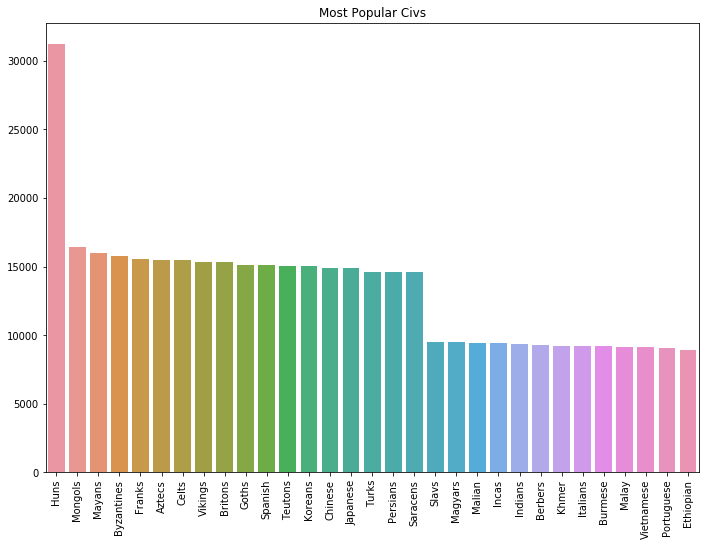

In [57]:
popularity = rm_1v1['MatchPlayerCivName'].value_counts()
dims = (11.7, 8.27)

fig, ax = plt.subplots(figsize=dims)
popchart = sns.barplot(ax=ax, x=popularity.index, y=popularity.values);
plt.title('Most Popular Civs');
popchart.set_xticklabels(labels = popularity.index, rotation=90);

In [58]:
rm_1v1['CivTier'] = rm_1v1['MatchPlayerCivId'].map(place_in_tier)
rm_1v1.head(5)

,MatchId,MatchMods,MatchMap,MatchDuration,MatchPlayerCivId,MatchPlayerCivName,MatchPlayerWinner,MatchPlayerPreRating,CivTier
728,18658367,"v1.5 Beta R7, WololoKingdoms",Arabia,1055,16,Mayans,1,1599,1
729,18658367,"v1.5 Beta R7, WololoKingdoms",Arabia,1055,11,Vikings,0,1600,1
730,18658419,1.4 RC,Custom,3361,18,Koreans,1,1629,3
731,18658419,1.4 RC,Custom,3361,17,Huns,0,1548,1
732,18658476,"v1.5 Beta R7, WololoKingdoms",Nomad,3369,6,Chinese,1,1975,1


In [0]:
# this takes forever I don't know why
# import pandas_profiling
# rm_1v1.profile_report()

# EDA and Wrangling Part 2 with all match data on column

In [59]:
# re-arranging dataframe since right now, odd player always wins which makes the model always guess player one wins

first_players = rm_1v1[::2]
second_players = rm_1v1[1::2]


first_players.shape, second_players.shape

((205562, 9), (205561, 9))

In [60]:
first_players.head(), second_players.head()

(      MatchId                     MatchMods MatchMap  MatchDuration  \
 728  18658367  v1.5 Beta R7, WololoKingdoms   Arabia           1055   
 730  18658419                        1.4 RC   Custom           3361   
 732  18658476  v1.5 Beta R7, WololoKingdoms    Nomad           3369   
 734  18658489                        1.4 RC   Custom           1891   
 736  18658492  v1.5 Beta R7, WololoKingdoms   Custom           3832   
 
      MatchPlayerCivId MatchPlayerCivName  MatchPlayerWinner  \
 728                16             Mayans                  1   
 730                18            Koreans                  1   
 732                 6            Chinese                  1   
 734                12            Mongols                  1   
 736                22            Magyars                  1   
 
      MatchPlayerPreRating  CivTier  
 728                  1599        1  
 730                  1629        3  
 732                  1975        1  
 734                  1415  

In [61]:
p2_names = {
    "MatchPlayerCivId" : "MatchPlayerCivId2",
    "MatchPlayerPreRating" : "MatchPlayerPreRating2",
    "MatchPlayerPostRating" : "MatchPlayerPostRating2",
    "MatchPlayerCivName" : "MatchPlayerCivName2",
    "CivTier" : "CivTier2"
}

second_players = second_players.rename(columns=p2_names)

drop_cols = ['MatchMods','MatchDuration','MatchPlayerWinner', 'MatchMap']
second_players = second_players.drop(labels=drop_cols, axis=1)

second_players.head()

,MatchId,MatchPlayerCivId2,MatchPlayerCivName2,MatchPlayerPreRating2,CivTier2
729,18658367,11,Vikings,1600,1
731,18658419,17,Huns,1548,1
733,18658476,17,Huns,2065,1
735,18658489,18,Koreans,1535,3
737,18658492,8,Persians,1600,2


In [0]:
# merge first and second players so each row has match data for both players since
# the features we care about are relative like their relative elo difference

rm_1v1 = first_players.merge(second_players, on='MatchId')


In [0]:
# set matchID as index

rm_1v1 = rm_1v1.set_index('MatchId')

In [64]:
# split set in half and reverse P1 and P2 in second half
# so half of the data has P1 and P2 as winner

from sklearn.model_selection import train_test_split

fst, snd = train_test_split(rm_1v1, train_size=0.5, test_size=0.5)

fst.shape, snd.shape

snd_names = {
    "MatchPlayerCivId" : "MatchPlayerCivId2",
    "MatchPlayerPreRating" : "MatchPlayerPreRating2",
    "MatchPlayerPostRating" : "MatchPlayerPostRating2",
    "MatchPlayerCivId2" : "MatchPlayerCivId",
    "MatchPlayerPreRating2" : "MatchPlayerPreRating",
    "MatchPlayerPostRating2" : "MatchPlayerPostRating"
}

snd = snd.rename(columns=snd_names)
snd['MatchPlayerWinner'] = snd['MatchPlayerWinner'].map({1:0})

snd = snd.fillna(0)

snd.head()


,MatchMods,MatchMap,MatchDuration,MatchPlayerCivId2,MatchPlayerCivName,MatchPlayerWinner,MatchPlayerPreRating2,CivTier,MatchPlayerCivId,MatchPlayerCivName2,MatchPlayerPreRating,CivTier2
MatchId,,,,,,,,,,,,
18980797,"v1.5 Beta R7, Small Trees - N",Nomad,2492,5,Japanese,0.0,1468,1,17,Huns,1600,1
19029906,"v1.5 Beta R7, WololoKingdoms",Custom,2279,6,Chinese,0.0,1462,1,8,Persians,1490,2
19017378,"v1.5 Beta R7, WololoKingdoms",Arabia,2336,30,Burmese,0.0,1673,3,8,Persians,1631,2
18919322,v1.5 Beta R7,Arabia,30,13,Celts,0.0,1500,2,15,Aztecs,1563,1
18751554,"v1.5 Beta R7, WololoKingdoms",Arena,2300,17,Huns,0.0,1964,1,13,Celts,1894,2


In [65]:
fst.head()

,MatchMods,MatchMap,MatchDuration,MatchPlayerCivId,MatchPlayerCivName,MatchPlayerWinner,MatchPlayerPreRating,CivTier,MatchPlayerCivId2,MatchPlayerCivName2,MatchPlayerPreRating2,CivTier2
MatchId,,,,,,,,,,,,
19126767,"v1.5 Beta R7, WololoKingdoms",Arena,2458,25,Ethiopian,0,1368,2,11,Vikings,1375,1
18918521,"v1.5 Beta R7, WololoKingdoms",Arabia,1013,21,Incas,1,1567,2,27,Berbers,1406,2
18754244,"v1.5 Beta R7, Allied Vision",Arabia,1633,3,Goths,0,1624,3,1,Britons,1625,1
18681069,v1.5 Beta R7,Custom,2149,12,Mongols,0,1346,1,15,Aztecs,1472,1
18708273,"v1.5 Beta R7, WololoKingdoms",Arabia,2095,16,Mayans,0,1644,1,2,Franks,1662,1


In [0]:
# data frame is finally ready to have features engineered

rm_1v1 = snd.append(fst, sort=True)

# Profile Report After Done Wrangling

In [143]:
# ask during standup why this takes forever to run

count    205317.000000
mean         -0.375205
std          97.612441
min       -1007.000000
25%         -51.000000
50%           0.000000
75%          51.000000
max         972.000000
Name: EloDifference, dtype: float64

# Feature Engineering 

In [69]:
rm_1v1['EloDifference'] = rm_1v1['MatchPlayerPreRating'] - rm_1v1['MatchPlayerPreRating2']
rm_1v1['CivAdvantage'] = rm_1v1['CivTier'] - rm_1v1['CivTier2']
rm_1v1.head()

,CivTier,CivTier2,MatchDuration,MatchMap,MatchMods,MatchPlayerCivId,MatchPlayerCivId2,MatchPlayerCivName,MatchPlayerCivName2,MatchPlayerPreRating,MatchPlayerPreRating2,MatchPlayerWinner,EloDifference,CivAdvantage
MatchId,,,,,,,,,,,,,,
18980797,1,1,2492,Nomad,"v1.5 Beta R7, Small Trees - N",17,5,Japanese,Huns,1600,1468,0.0,132,0
19029906,1,2,2279,Custom,"v1.5 Beta R7, WololoKingdoms",8,6,Chinese,Persians,1490,1462,0.0,28,-1
19017378,3,2,2336,Arabia,"v1.5 Beta R7, WololoKingdoms",8,30,Burmese,Persians,1631,1673,0.0,-42,1
18919322,2,1,30,Arabia,v1.5 Beta R7,15,13,Celts,Aztecs,1563,1500,0.0,63,1
18751554,1,2,2300,Arena,"v1.5 Beta R7, WololoKingdoms",13,17,Huns,Celts,1894,1964,0.0,-70,-1


In [70]:
rm_1v1.columns

Index(['CivTier', 'CivTier2', 'MatchDuration', 'MatchMap', 'MatchMods',
       'MatchPlayerCivId', 'MatchPlayerCivId2', 'MatchPlayerCivName',
       'MatchPlayerCivName2', 'MatchPlayerPreRating', 'MatchPlayerPreRating2',
       'MatchPlayerWinner', 'EloDifference', 'CivAdvantage'],
      dtype='object')

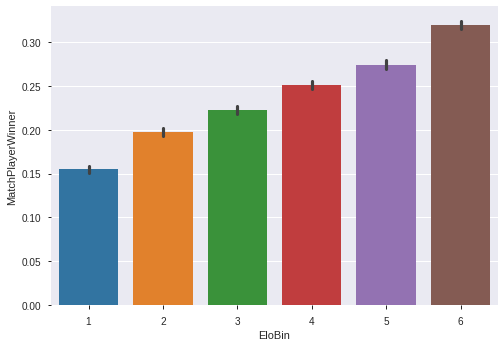

In [71]:
rm_1v1['EloBin'] = pd.qcut(rm_1v1['EloDifference'], 6, labels=[1,2,3,4,5,6])

sns.barplot(x='EloBin', y='MatchPlayerWinner', data=rm_1v1);

# ok this looks reasonable, a lot lower than expected because of smurfs but
# will address difficulty of smurf detection/lack of 'trueElo' in blog

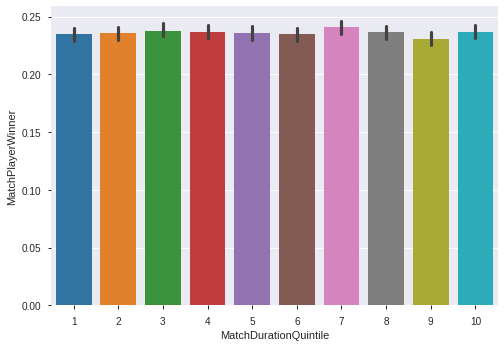

In [72]:
rm_1v1['MatchDurationQuintile'] = pd.qcut(rm_1v1['MatchDuration'], 10, labels=[1,2,3,4,5,6,7,8,9,10])

sns.barplot(x='MatchDurationQuintile', y='MatchPlayerWinner', data=rm_1v1);

# ok this is useless by itself, let's see if any factions are rush/late game
# and make a feature around that

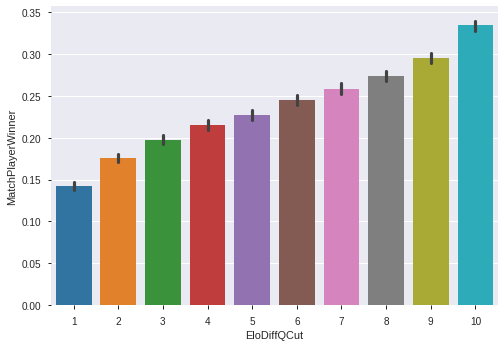

In [73]:
rm_1v1['EloDiffQCut'] = pd.qcut(rm_1v1['EloDifference'], 10, labels=[1,2,3,4,5,6,7,8,9,10])

sns.barplot(x='EloDiffQCut', y='MatchPlayerWinner', data=rm_1v1);

# not sure why it does an inverse color thing above
# TODO: remove bottom margin labels
# again, the smurfing is ruining it 

In [0]:
tiered = rm_1v1.groupby('CivTier')


In [0]:
# graph by groupby
# a4_dims = (11.7, 8.27)


# fig, ax = plt.subplots(figsize=a4_dims)
# winrates = sns.barplot(ax=ax, x='MatchPlayerCivName', y='MatchPlayerWinner', data=tiered); 
# plt.title('Win Rates for Civs');
# winrates.set_xticklabels(winrates.get_xticklabels(), rotation=90);

In [155]:
rm_1v1.head()

,CivTier,CivTier2,MatchDuration,MatchMap,MatchMods,MatchPlayerCivId,MatchPlayerCivId2,MatchPlayerCivName,MatchPlayerCivName2,MatchPlayerPreRating,MatchPlayerPreRating2,MatchPlayerWinner,EloDifference,CivAdvantage,EloBin,MatchDurationQuintile,EloDiffQCut
MatchId,,,,,,,,,,,,,,,,,
18980797,1,1,2492,Nomad,"v1.5 Beta R7, Small Trees - N",17,5,Japanese,Huns,1600,1468,0.0,132,0,6,6,10
19029906,1,2,2279,Custom,"v1.5 Beta R7, WololoKingdoms",8,6,Chinese,Persians,1490,1462,0.0,28,-1,4,5,7
19017378,3,2,2336,Arabia,"v1.5 Beta R7, WololoKingdoms",8,30,Burmese,Persians,1631,1673,0.0,-42,1,2,5,3
18919322,2,1,30,Arabia,v1.5 Beta R7,15,13,Celts,Aztecs,1563,1500,0.0,63,1,5,1,8
18751554,1,2,2300,Arena,"v1.5 Beta R7, WololoKingdoms",13,17,Huns,Celts,1894,1964,0.0,-70,-1,2,5,2


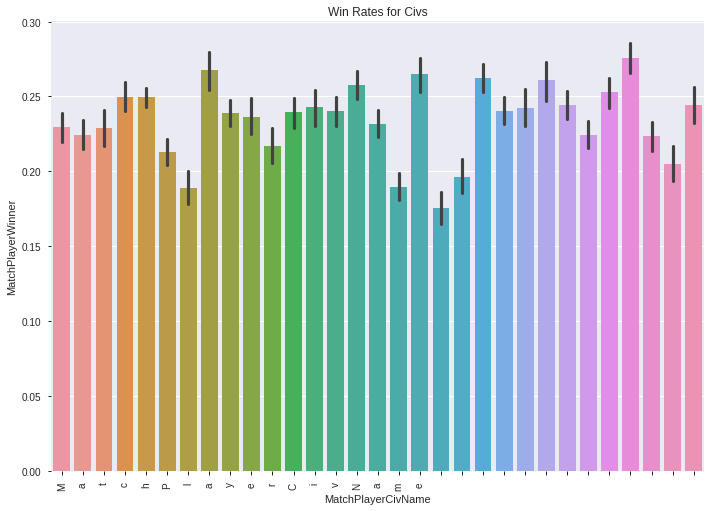

In [161]:
a4_dims = (11.7, 8.27)

fig, ax = plt.subplots(figsize=a4_dims)
winrates = sns.barplot(ax=ax, x='MatchPlayerCivName', y='MatchPlayerWinner', data=rm_1v1); 
plt.title('Win Rates for Civs');
winrates.set_xticklabels(labels = 'MatchPlayerCivName', rotation=90);

In [0]:
rm_1v1['MatchMods'].value_counts()

# I don't play with balance mods and have no idea how these influence balance
# Outside of time budget
# However I do know that cosmetic mods are optional and one sided only
# Like with removing shrubs and smaller trees and these do give an advantage

Wololo Kingdoms vs Vanilla Win Rates from Reddit

![Wololo Kingdoms vs Vanilla Game](https://i.redd.it/b5x2mnh608w01.png)

In [87]:
rm_1v1.columns

Index(['CivTier', 'CivTier2', 'MatchDuration', 'MatchMap', 'MatchMods',
       'MatchPlayerCivId', 'MatchPlayerCivId2', 'MatchPlayerCivName',
       'MatchPlayerCivName2', 'MatchPlayerPreRating', 'MatchPlayerPreRating2',
       'MatchPlayerWinner', 'EloDifference', 'CivAdvantage', 'EloBin',
       'MatchDurationQuintile', 'EloDiffQCut'],
      dtype='object')

In [0]:
from sklearn.metrics import confusion_matrix

def matrix(y_true, y_pred):
  data = confusion_matrix(y_true, y_pred)
  index = ['Predicted True', 'Predicted False']
  columns = ['Reality True', 'Reality False']
  return pd.DataFrame(data, index, columns)

import seaborn as sns
def plot_confusion_matrix(y_true, y_pred):

    index = ['Predicted True', 'Predicted False']
    columns = ['Reality True', 'Reality False']

    table = pd.DataFrame(confusion_matrix(y_true, y_pred), columns=columns, index=index)
    return sns.heatmap(table, annot=True, fmt='d', cmap='Greens')





# PREP DATA FOR MODEL

In [128]:
# train test split
from sklearn.model_selection import train_test_split

train, test = train_test_split(rm_1v1, train_size = 0.8, test_size = 0.2)

train.shape, test.shape



((164253, 17), (41064, 17))

In [129]:
val, test = train_test_split(test, test_size = .5)

val.shape, test.shape

((20532, 17), (20532, 17))

In [0]:
# set up features for linear model
target = 'MatchPlayerWinner'
features = [
           # 'MatchMods', 
           # 'MatchMap', 
           # 'MatchDuration',
       # 'MatchPlayerCivId', 
       # 'MatchPlayerPreRating',
       # 'MatchPlayerCivId2', 
       # 'MatchPlayerPreRating2',
        'EloDifference', 
        'CivAdvantage',
        'EloBin'
      ]
X_train = train[features]
y_train = train[target]

X_val = val[features]
y_val = val[target]

# Linear Regression

In [131]:
# can't get above like 2% no matter what I try which is way below baseline of 50%

from sklearn import linear_model
pipeline = make_pipeline(
    ce.OrdinalEncoder(), 
    linear_model.LinearRegression()
)

pipeline.fit(X_train, y_train)

y_pred = pipeline.predict(X_val)

print('Train Accuracy', pipeline.score(X_train, y_train))

print('Validation Accuracy', pipeline.score(X_val, y_val))

Train Accuracy 0.0189375617032943
Validation Accuracy 0.021779348193128545


In [0]:
# set up features for non linear models
target = 'MatchPlayerWinner'
features = [
            'MatchMods', 
            'MatchMap', 
           # 'MatchDuration',
        'MatchPlayerCivId', 
      #  'MatchPlayerPreRating',
        'MatchPlayerCivId2', 
     #   'MatchPlayerPreRating2',
        'EloDifference', 
        'CivAdvantage',
        'EloBin']
X_train = train[features]
y_train = train[target]

X_val = val[features]
y_val = val[target]
X_test = test[features]
y_test = test[target]

# Random Forest

In [147]:
from sklearn.ensemble import RandomForestClassifier
pipeline = make_pipeline(
    ce.OrdinalEncoder(), 
    RandomForestClassifier(n_estimators = 100, n_jobs=-1)
)

pipeline.fit(X_train, y_train)

y_pred = pipeline.predict(X_val)

print('Train Accuracy', pipeline.score(X_train, y_train))

print('Validation Accuracy', pipeline.score(X_val, y_val))

Train Accuracy 1.0
Validation Accuracy 0.7904734073641145


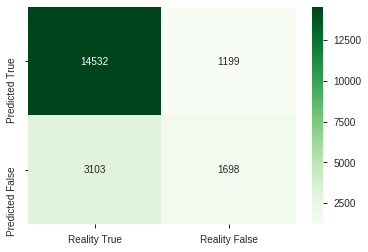

In [148]:
y_pred = pipeline.predict(X_val)

plot_confusion_matrix(y_val, y_pred);

# XGBClassifier

In [145]:
from xgboost import XGBClassifier
pipeline = make_pipeline(
    ce.OrdinalEncoder(), 
    XGBClassifier(n_estimators=100, random_state=42, n_jobs=-1)
)

pipeline.fit(X_train, y_train)

y_pred = pipeline.predict(X_val)

print('Train Accuracy', pipeline.score(X_train, y_train))

print('Validation Accuracy', pipeline.score(X_val, y_val))

Train Accuracy 0.7731670045600385
Validation Accuracy 0.7744983440483149


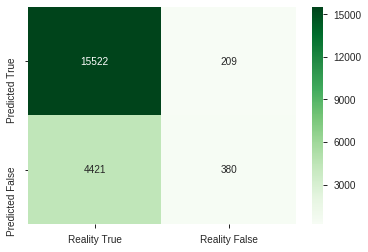

In [146]:
y_pred = pipeline.predict(X_val)

plot_confusion_matrix(y_val, y_pred);

# Decision Tree

In [136]:
from sklearn.tree import DecisionTreeClassifier

pipeline = make_pipeline(
    ce.OrdinalEncoder(),
    
    DecisionTreeClassifier(random_state=42)
)

pipeline.fit(X_train, y_train)

y_pred = pipeline.predict(X_val)

print('Train Accuracy', pipeline.score(X_train, y_train))

print('Validation Accuracy', pipeline.score(X_val, y_val))

print('Test Accuracy', pipeline.score(X_test, y_test))

# above baseline

Train Accuracy 0.9747523637315605
Validation Accuracy 0.7261348139489577
Test Accuracy 0.7233099551918956


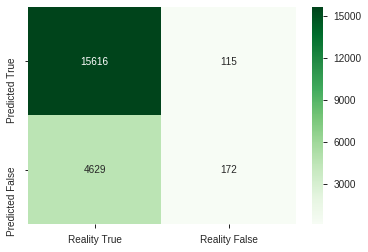

In [142]:
y_pred = pipeline.predict(X_val)

plot_confusion_matrix(y_val, y_pred);

# ROC AUC for Decision Tree

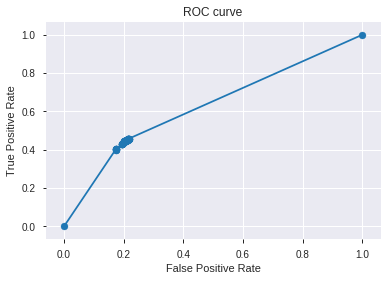

In [137]:
# ROC AUC
from sklearn.metrics import roc_curve
y_pred_proba = pipeline.predict_proba(X_val)[:, -1] 
fpr, tpr, thresholds = roc_curve(y_val, y_pred_proba)

pd.DataFrame({
    'False Positive Rate': fpr, 
    'True Positive Rate': tpr, 
    'Threshold': thresholds
})

import matplotlib.pyplot as plt
plt.scatter(fpr, tpr)
plt.plot(fpr, tpr)
plt.title('ROC curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate');

In [138]:
from sklearn.metrics import roc_auc_score
roc_auc_score(y_val, y_pred_proba)

0.6241798641556608

# CV for Decision Tree

In [139]:
import category_encoders as ce
from sklearn.pipeline import make_pipeline
from sklearn.tree import DecisionTreeClassifier
#from sklearn.ensemble import RandomForestClassifier
from sklearn.impute import SimpleImputer
from sklearn.model_selection import cross_val_score

target = 'MatchPlayerWinner'
features = train.columns.drop([target])
X_train = train[features]
y_train = train[target]
X_val = val[features]
y_val = val[target]
X_test = test[features]
y_test = test[target]

pipeline = make_pipeline(
    ce.OrdinalEncoder(),
    DecisionTreeClassifier(
        max_depth=6, min_samples_leaf=50)
    # RandomForestClassifier()
)

pipeline.fit(X_train, y_train)
print('Validation Accuracy', pipeline.score(X_val, y_val))

k = 5
scores = cross_val_score(pipeline, X_train, y_train, cv=k, 
                         scoring='neg_mean_absolute_error')
print(f'MAE for {k} folds:', -scores)

Validation Accuracy 0.7689460354568478
MAE for 5 folds: [0.23442209 0.23125628 0.2351831  0.23378995 0.23305936]


# Feature Importances for Decision Tree

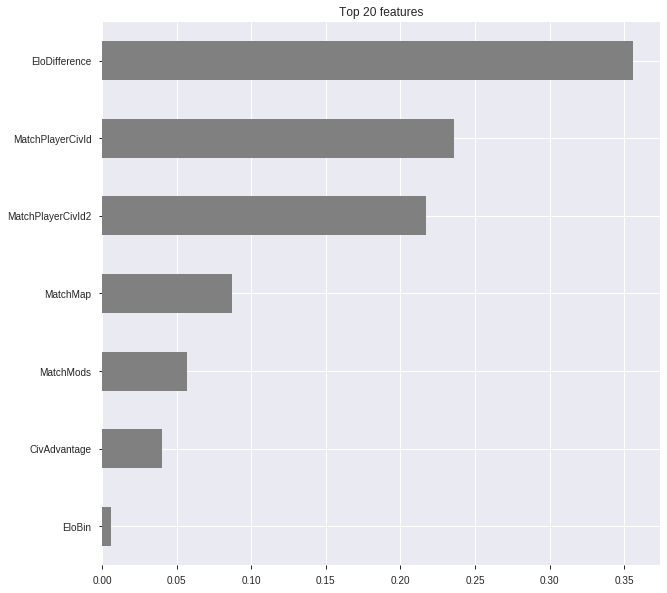

In [117]:
rf = pipeline.named_steps['decisiontreeclassifier']
importances = pd.Series(rf.feature_importances_, X_train.columns)

%matplotlib inline
import matplotlib.pyplot as plt

n=20

plt.figure(figsize=(10,n/2))
plt.title(f'Top {n} features')
importances.sort_values()[-n:].plot.barh(color='grey');

In [0]:
# don't use 
# sns.barplot(x='MatchDurationQuintile', y='MatchPlayerWinner', data=rm_1v1);

# um, o . . . k

# PDP and Shapely Plots

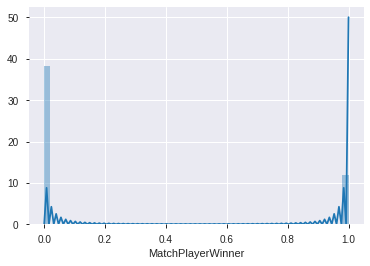

In [95]:
sns.distplot(y_train);

In [96]:
import category_encoders as ce
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

lr = make_pipeline(
    ce.TargetEncoder(),  
    LinearRegression()
)

lr.fit(X_train, y_train)
print('Linear Regression R^2', lr.score(X_val, y_val))

# slightly above baseline!

Linear Regression R^2 0.015919046896767042


In [97]:
# TODO: see if can get higher

from sklearn.metrics import r2_score, accuracy_score
from xgboost import XGBRegressor

gb = make_pipeline(
    ce.OrdinalEncoder(),
    XGBRegressor(n_estimators=200, objective='reg:squarederror', n_jobs=-1)
)

gb.fit(X_train, y_train)
y_pred = gb.predict(X_val)
print('Gradient Boosting R^2', r2_score(y_val, y_pred))


/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/usr/local/lib/python3.6/dist-packages/xgboost/core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


Gradient Boosting R^2 0.1529065472815524


In [0]:
# increase the dots per inch (double it), so the text isn't so fuzzy
import matplotlib.pyplot as plt


     |████████████████████████████████| 57.7MB 60kB/s 
  Created wheel for pdpbox: filename=PDPbox-0.2.0-cp36-none-any.whl size=57690723 sha256=df0a4263ff3dfd2d77b6216377232bf2ba7ff01cb3830d0afcc660dd9e99a5aa
  Stored in directory: /root/.cache/pip/wheels/7d/08/51/63fd122b04a2c87d780464eeffb94867c75bd96a64d500a3fe
Successfully built pdpbox
     |████████████████████████████████| 266kB 9.9MB/s 
  Created wheel for shap: filename=shap-0.34.0-cp36-cp36m-linux_x86_64.whl size=383192 sha256=994de011b7b06c82a9667cd0795094670f67538045041a77d9e37479820669e3
  Stored in directory: /root/.cache/pip/wheels/28/7e/28/57bc9fcb77579b0df6561298648249370648c0b91dfe42c8ec
Successfully built shap


(<Figure size 1080x684 with 2 Axes>,
 {'pdp_ax': <matplotlib.axes._subplots.AxesSubplot at 0x7fdcd78fcb00>,
  'title_ax': <matplotlib.axes._subplots.AxesSubplot at 0x7fdcd7908c50>})

findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.


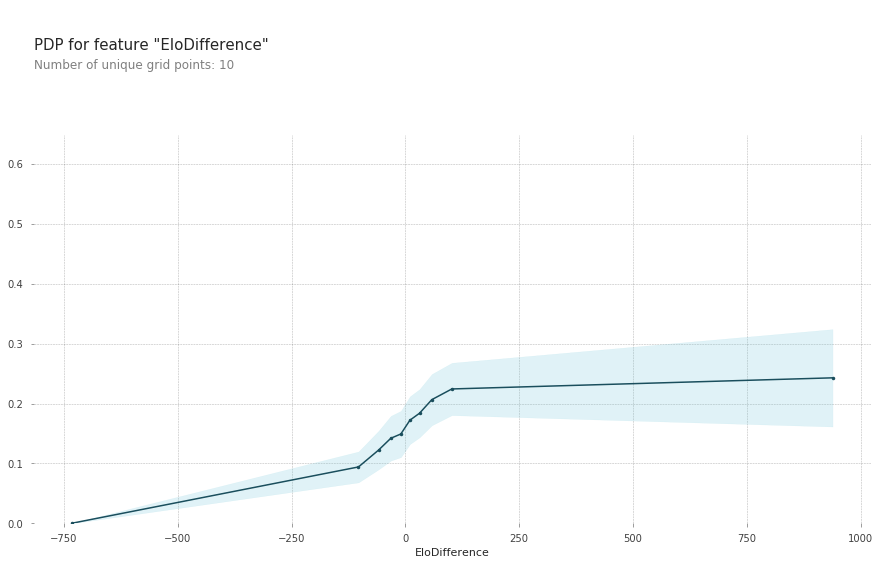

In [99]:
if 'google.colab' in sys.modules:

      !pip install pdpbox
      !pip install shap

from pdpbox.pdp import pdp_isolate, pdp_plot

feature = 'EloDifference'

isolated = pdp_isolate(
    model=gb, 
    dataset=X_val, 
    model_features=X_val.columns, 
    feature=feature
)

pdp_plot(isolated, feature_name=feature)

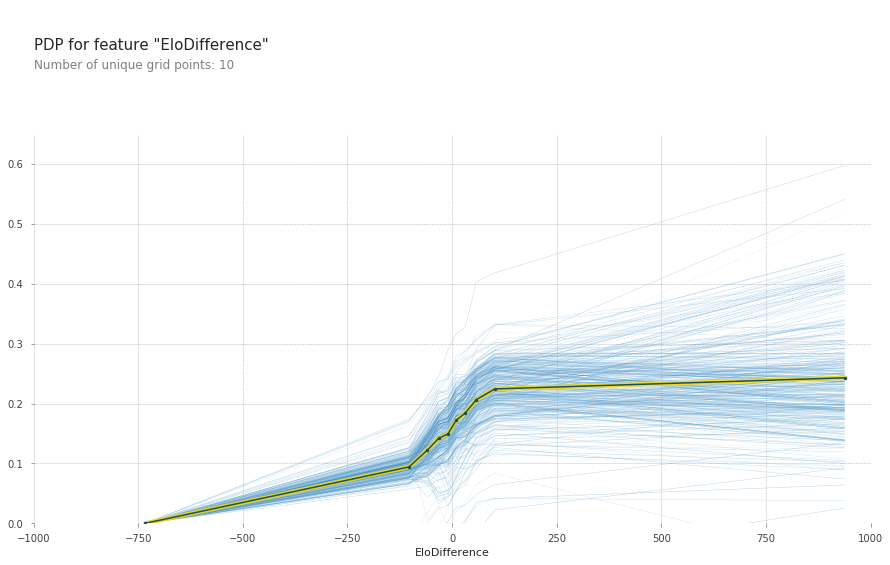

In [100]:
# Plot PDP with 100 ICE curves
# PDP: Partial Dependence Plot
# ICE: Individual Conditional Expectation
pdp_plot(isolated, feature_name=feature, plot_lines=True, 
         frac_to_plot=0.01)

plt.xlim(-1000,1000);

In [101]:
rm_1v1.MatchDuration.describe()

count    205317.000000
mean       2474.787076
std        1145.952642
min           5.000000
25%        1738.000000
50%        2439.000000
75%        3085.000000
max       38404.000000
Name: MatchDuration, dtype: float64

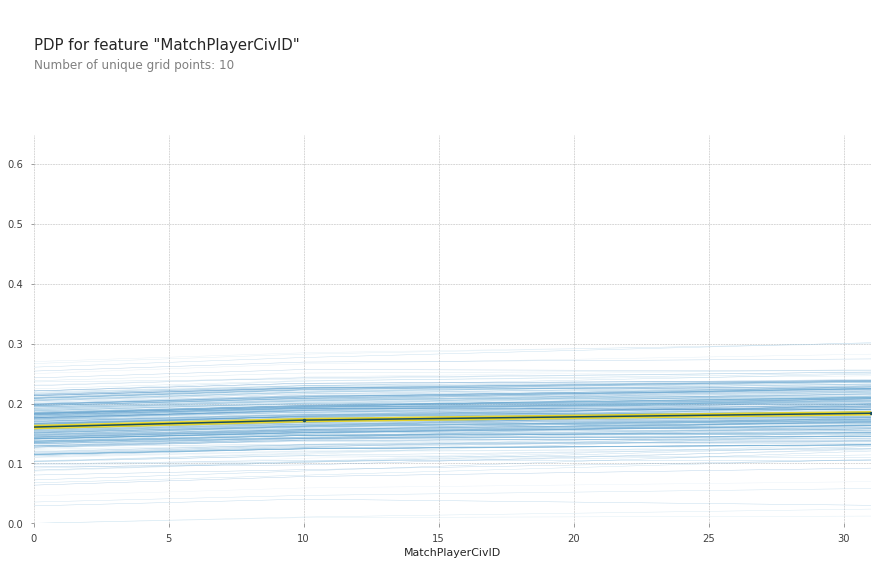

In [122]:
pdp_plot(isolated, feature_name='MatchPlayerCivID', plot_lines=True, 
         frac_to_plot=0.01)


plt.xlim(0,31);

In [149]:
rm_1v1['EloDifference'].describe()

count    205317.000000
mean         -0.375205
std          97.612441
min       -1007.000000
25%         -51.000000
50%           0.000000
75%          51.000000
max         972.000000
Name: EloDifference, dtype: float64